# Реализация внесения искажений в слова (Гареева)

### Функция сложности слова

In [1]:
%run scripts/word_difficulty.py

### Получение морфем слова

Многие неочевидные места в правописании слова зависят от морфемы и ударения, поэтому было бы здорово учитывать их, если это возможно.

In [2]:
def get_morphs_list(lemma: str) -> List[str]:
    if lemma not in morph_df.index:
        return []
    return list(morph_df.loc[lemma]['analysis'].split('/'))

Протестируем

In [3]:
word='недисциплинированный'
print(get_morphs_list(lemma=word))

['не', 'дисциплин', "и'р", 'ова', 'нн', 'ый']


### Безударные гласные

Будем заменять безударные О и Е в слове на А и И. Определять безударность с помощью списка морфем с ударениями. Если определить морфемы не вышло, будем заменять в любом случае.

In [4]:
stress_vowels_dict = {'о':'а', 'е':'и'}

def stress_vowels_distortion(word: str, morphs_list: List[str]=[]) -> List[str]:  
    def do_distortion(word: str) -> None:
        stress_word = word
        if morphs_list:
            morphs_str = ''.join(morphs_list)
            stress = 0
            for i in range(len(morphs_str)):
                if morphs_str[i] == '\'':
                    stress_word = stress_word[:i - stress - 1] + morphs_str[i - 1].upper() + morphs_str[i + 1:] 
                    stress += 1
        for i in range(len(word) - 1):
            if i < len(stress_word) and stress_word[i] in stress_vowels_dict and stress_word[i] == word[i]:
                distortion = word[:i] + stress_vowels_dict[word[i]] + word[i + 1:]
                if distortion not in distortions:
                    distortions.add(distortion)
                    do_distortion(distortion)
        
    distortions = set()
    do_distortion(word)
    return list(distortions)

Протестируем

In [5]:
word='музыкально-литературный'
print(stress_vowels_distortion(word, morphs_list=get_morphs_list(word)))
word='снегоуборочный'
print(stress_vowels_distortion(word, morphs_list=get_morphs_list(word)))
word='гриб'
print(stress_vowels_distortion(word, morphs_list=get_morphs_list(word)))

['музыкальна-литиратурный', 'музыкально-литиратурный', 'музыкальна-литературный']
['снегауборачный', 'снигоуборочный', 'снигауборачный', 'снигауборочный', 'снегоуборачный', 'снегауборочный', 'снигоуборачный']
[]


### Парные по глухости/звонкости согласные

Заменим парные согласные в конце слова или перед глухими на их пару.

In [6]:
deaf_consonants = set('пфктшсхцчщ')
consonants_pairs = {
    'б':'п', 'п':'б',
    'в':'ф', 'ф':'в',
    'г':'к', 'к':'г',
    'д':'т', 'т':'д',
    'ж':'ш', 'ш':'ж',
    'з':'с', 'с':'з'
}

def consonants_distortion(word: str) -> List[str]:  
    def do_distortion(word: str) -> None:
        for i in range(len(word)):
            distortion = None
            c = word[i] 
            after_c = word[i + 1] if i < len(word) - 1 else None
            if c in deaf_pairs and (i == len(word) - 1 or after_c in deaf_consonants):
                distortion = word[:i] + consonants_pairs[c] + word[i + 1:]
                if distortion not in distortions:
                    distortions.add(distortion)
                    do_distortion(distortion)
        
    distortions = set()
    do_distortion(word)
    return list(distortions)

Протестируем

In [7]:
word='случившиеся'
print(consonants_distortion(word))
word='гриб'
print(consonants_distortion(word))
word='отвориться'
print(consonants_distortion(word))

['случифшиеся']
['грип']
[]


### Гласные после шипящих и Ц

Заменим все возможные гласные после шипящих и Ц на их двойников.

In [8]:
hissing = set('жчшщ')
vowels_pairs = {'ю':'у', 'у':'ю', 'я':'а', 'а':'я', 'ы':'и', 'и':'ы'}

def vowels_hissing_distortion(word: str) -> List[str]:  
    def do_distortion(word: str) -> None:
        for i in range(len(word)):
            distortion = None
            c = word[i] 
            before_c = word[i - 1] if i > 0 else None
            if before_c in hissing or before_c == 'ц':
                if c in vowels_pairs:
                    distortion = word[:i] + vowels_pairs[c] + word[i + 1:]
            if before_c in hissing:
                if c == 'ё':
                    distortion = word[:i] + 'о' + word[i + 1:]
            if distortion and distortion not in distortions:
                distortions.add(distortion)
                do_distortion(distortion)
        
    distortions = set()
    do_distortion(word)
    return list(distortions)

Протестируем

In [9]:
word='случившиеся'
print(vowels_hissing_distortion(word))
word='чёрное'
print(vowels_hissing_distortion(word))
word='отвориться'
print(vowels_hissing_distortion(word))

['случывшыеся', 'случившиеся', 'случившыеся', 'случывшиеся']
['чорное']
[]


### Чередование безударных гласных в корне

Заменим корни с помощью спика морфем на их пару.

In [10]:
root_pairs = {'раст':'рост', 'ращ':'рощ', 'рос':'рас',
               'лаг':'лог', 'лож':'лаж',
               'скак':'скок', 'скоч':'скач',
               'гар':'гор', 'гор':'гар', 
               'твар':'твор','твор':'твар', 
               'клан':'клон', 'клон':'клан',
               'зар':'зор', 'зор':'зар',
               'плав':'плов', 'плов':'плав',
               'мак':'мок', 'моч':'мач',
               'равн':'ровн', 'ровн':'равн',
               'бер':'бир', 'бир':'бер',
               'дер':'дир', 'дир':'дер',
               'пер':'пир', 'пир':'пер',
               'тер':'тир', 'тир':'тер',
               'мер':'мир', 'мир':'мер',
               'жег':'жиг', 'жиг':'жег',
               'стел':'стил', 'стил':'стел',
               'блест':'блист', 'блист':'блест',
               'чет':'чит', 'чит':'чет',
               'кас':'кос', 'кос':'кас'}

    
def roots_distortion(word: str, morphs_list: List[str]=[]) -> List[str]:
    def do_distortion(word: str) -> None:
        index = 0
        for morph in morphs_list:
            if morph in root_pairs and morph == word[index:index + len(morph)]:
                distortion = word[:index] + root_pairs[morph] + word[index + len(morph):]
                if distortion not in distortions:
                    distortions.add(distortion)
                    do_distortion(distortion)
            index += len(morph.replace('\'', ''))

    distortions = set()
    do_distortion(word)
    return list(distortions)

Протестируем

In [11]:
word = 'отвориться'
print(roots_distortion(word, morphs_list=get_morphs_list(word)))
word = 'послушаться'
print(roots_distortion(word, morphs_list=get_morphs_list(word)))

['отвариться']
[]


### Правописание приставок

Заменим приставки с помощью спика морфем на их пару. Если найти морфемы или приставки не удалось, попробуем заменить префикс слова.

In [12]:
prefix_pairs = {'пре':'при', 'при':'пре',
                'без':'бес', 'бес':'без',
                'воз':'вос', 'вос':'воз',
                'вз':'вс', 'вс':'вз',
                'из':'ис', 'ис':'из',
                'низ':'нис', 'нис':'низ',
                'раз':'рас', 'рас':'раз',
                'чрез':'чрес', 'чрес':'чрез'}

def prefixs_distortion(word: str, morphs_list: List[str]=[]) -> List[str]:
    def do_distortion(word: str) -> None:
        index = 0
        for morph in morphs_list:
            if morph in prefix_pairs and morph == word[index:index + len(morph)]:
                distortion = word[:index] + prefix_pairs[morph] + word[index + len(morph):]
                if distortion not in distortions:
                    distortions.add(distortion)
                    do_distortion(distortion)
            index += len(morph.replace('\'', ''))
        if len(distortions) == 0:
            for key, value in prefix_pairs.items():
                distortion = word.replace(value, key, 1)
                if distortion != word:
                    distortions.add(distortion)
            
    distortions = set()
    do_distortion(word)
    return list(distortions)

Протестируем

In [13]:
word = 'приподняться'
print(prefixs_distortion(word, morphs_list=get_morphs_list(word)))
word = 'бесприданница'
print(prefixs_distortion(word, morphs_list=get_morphs_list(word)))
word = 'приключениях'
print(prefixs_distortion(word, morphs_list=get_morphs_list(word)))
word = 'отвориться'
print(prefixs_distortion(word, morphs_list=get_morphs_list(word)))

['преподняться']
['беспреданница', 'безприданница', 'безпреданница']
['преключениях']
[]


### Правописание ться/тся

Заменим постфикс слова ться на тся и наоборот.

In [14]:
postfix_pairs = {'тся':'ться', 'ться':'тся'}

def postfixs_distortion(word: str) -> List[str]:
    for postfix in postfix_pairs:
        if word[-len(postfix):] == postfix:
            return [word[:-len(postfix)] + postfix_pairs[postfix]]
    return []

Протестируем

In [15]:
word = 'приподняться'
print(postfixs_distortion(word))
word = 'приподнятся'
print(postfixs_distortion(word))
word = 'приподнялась'
print(postfixs_distortion(word))

['приподнятся']
['приподняться']
[]


### Двойные согласные

Удалим двойные согласные и добавим лишнюю н у суффиксов ан, ян, ын, ин.

In [16]:
vowels = set('аяоёуюыиэе')

def two_in_row_distortion(word: str) -> List[str]:
    def do_distortion(word: str) -> None:
        for i in range(len(word) - 2):
            if i > 0 and word[i - 1] == word[i] and word[i] not in vowels:
                distortion = word[:i] + word[i + 1:]
                if distortion not in distortions:
                    distortions.add(distortion)
                    do_distortion(distortion)
            
    distortions = set()
    do_distortion(word)
    return list(distortions)

single_suffixs = set(['ан', 'ян', 'ын', 'ин'])

def duplicate_distortion(word: str, morphs_list: List[str]) -> List[str]:
    def do_distortion(word: str) -> None:
        index = 0
        for morph in morphs_list:
            morph = morph.replace('\'', '')
            if morph in single_suffixs and morph == word[index:index + len(morph)] and\
                index + len(morph) < len(word) and word[index + len(morph) - 1] != word[index + len(morph)]:
                    distortion = word[:index] + morph + 'н' + word[index + len(morph):]
                    if distortion not in distortions:
                        distortions.add(distortion)
                        do_distortion(distortion)
            index += len(morph)
            
    distortions = set()
    do_distortion(word)
    return list(distortions)

Протестируем

In [17]:
word = 'беззаконный'
print(two_in_row_distortion(word))
word = 'костяной'
print(two_in_row_distortion(word))
word = 'беззаконный'
print(duplicate_distortion(word, morphs_list=get_morphs_list(word)))
word = 'костяной'
print(duplicate_distortion(word, morphs_list=get_morphs_list(word)))

['безаконый', 'безаконный', 'беззаконый']
[]
[]
['костянной']


### Непроизносимые согласные

Удалим непроизносимую букву в наборе подряд идущих согласных. Если таких не нашлось. Поробуем добавить эту лишнюю букву.

In [18]:
silent_consonants_dict = {'стн':'сн',
                          'стл':'сл',
                          'ндш':'нш',
                          'ндц':'нц',
                          'нтг':'нг',
                          'здн':'зн',
                          'здц':'зц',
                          'рдц':'рц',
                          'рдч':'рч',
                          'лнц':'нц',
                          'вств':'ств'}

def silent_consonants_distortion(word: str) -> List[str]:
    def do_distortion(word: str) -> None:
        for key, value in silent_consonants_dict.items():
            distortion = word.replace(key, value, 1)
            if distortion != word and distortion not in distortions:
                distortions.add(distortion)
                do_distortion(distortion)
        if len(distortions) == 0:
            for key, value in silent_consonants_dict.items():
                distortion = word.replace(value, key, 1)
                if distortion != word:
                    distortions.add(distortion)
    
    distortions = set()
    do_distortion(word)
    return list(distortions)

Протестируем

In [19]:
word = 'солнце'
print(silent_consonants_distortion(word))
word = 'чувство'
print(silent_consonants_distortion(word))
word = 'ужасный'
print(silent_consonants_distortion(word))
word = 'стнстл'
print(silent_consonants_distortion(word))
word = 'костяной'
print(silent_consonants_distortion(word))

['сонце']
['чуство']
['ужастный']
['снстл', 'снсл', 'стнсл']
[]


### Твердый знак

Заменим твердый знак на мягкий.

In [20]:
def hard_sign_distortion(word: str) -> List[str]:
    if 'ъ' in set(word):
        return [word.replace('ъ', 'ь', 1)]
    return []

Протестируем

In [21]:
word = 'объём'
print(hard_sign_distortion(word))
word = 'солнце'
print(hard_sign_distortion(word))

['обьём']
[]


### Дефисные написания

Уберем дефисы или заменим на пробел.

In [22]:
def hyphen_distortion(word: str) -> List[str]:
    if '-' in set(word):
        return [word.replace('-', ' '), word.replace('-', '')]
    return []

Протестируем

In [23]:
word = 'все-таки'
print(hyphen_distortion(word))
word = 'костяной'
print(hyphen_distortion(word))

['все таки', 'всетаки']
[]


### Финальная функция внесения искажений в слова

Скомбинируем все созданные искажения, начиная с более узких правил, которые зависят от морфем, заканчивая самыми простыми заменями согласных и гласных. Ограничим количество полученных искажений переменной **max_amount**.

In [24]:
def create_distortions(word: str, lemma: str, max_amount: int=6) -> List[str]:
    morphs_list=get_morphs_list(lemma)    
    distortions = set([word])
    
    def do_function(func, morphs=False) -> None:
        result = set()
        for distortion in distortions:     
            result.update(func(distortion, morphs_list) if morphs else func(distortion))
        if len(distortions | result) <= max_amount:
            distortions.update(result)     

    do_function(roots_distortion, morphs=True)
    do_function(prefixs_distortion, morphs=True)
    do_function(postfixs_distortion)
    do_function(two_in_row_distortion)
    do_function(duplicate_distortion, morphs=True)
    do_function(silent_consonants_distortion)
    do_function(hard_sign_distortion)
    do_function(hyphen_distortion)
    do_function(stress_vowels_distortion, morphs=True)
    do_function(consonants_distortion)
    do_function(vowels_hissing_distortion)
    
    distortions.remove(word)
    return list(distortions)

Протестируем

In [25]:
print(create_distortions(word='собирается', lemma='собираться'))
print(create_distortions(word='престаринного', lemma='престаринный'))

['собераеться', 'соберается', 'собираеться']
['пристаринного', 'престариного', 'пристариного']


### Проверка работы функции

Напишем функции для создания датасета слов повышенной сложности с искажениями из текстового документа со словами и визуализации количества полученных искажений.

In [26]:
def countplot_distortions_df(distortions_df: pd.DataFrame) -> None:
    print('Всего слов: {}'.format(len(distortions_df)))
    print('Слов без искажений: {}'.format(len(distortions_df[distortions_df['distortions_amount'] == 0])))
    print('Слов с искажениями: {}'.format(len(distortions_df[distortions_df['distortions_amount'] != 0])))
    
    fig, ax = plt.subplots(figsize=(8, 4))
    
    sns.countplot(x=distortions_df[distortions_df['distortions_amount'] != 0]['distortions_amount'])
    ax.set_title('Количество слов с определенном количеством искажений')
    ax.set_ylabel('Количество слов')
    ax.set_xlabel('Количество искажений')
    
    plt.show()
    
def analyze_distortions(filepath: str, stop=None, show_plot=True) -> pd.DataFrame:
    distortions_df = pd.DataFrame(columns=['distortions', 'distortions_amount'])
    with open(filepath, 'rb') as f:
        for i, word in enumerate(tqdm(f.read().decode('utf-8').split())):
            word = transform_word(word)[0]
            if word and word not in distortions_df.index:
                difficulty = word_difficulty(word)
                if 0.5 <= difficulty['difficulty']:
                    distortions = create_distortions(word, difficulty['lemma'])
                    info = {'distortions': distortions,
                            'distortions_amount': len(distortions),
                            'difficulty': difficulty['difficulty']}
                    row = pd.Series(info, name=word)
                    distortions_df = distortions_df.append(row)
            if stop and stop <= i:
                break
    if show_plot:
        countplot_distortions_df(distortions_df)
    return distortions_df

Возьмем небольшой текст, чтобы мы могли протестировать внесение искажений. Например, отрывок из 'Алисы в стране чудес' Льюиса Кэрролла.

In [27]:
alice_in_wonderland_fullname = save_zip_txt(url='https://royallib.com/get/txt/keroll_lyuis/alisa_v_strane_chudes.zip',
                                     dirname='datasets/texts/alice_in_wonderland/',
                                     new_filename='alice_in_wonderland.txt')

100%|██████████████████████████████████████████████████████████████████████████| 28613/28613 [00:27<00:00, 1033.66it/s]


Всего слов: 1431
Слов без искажений: 152
Слов с искажениями: 1279


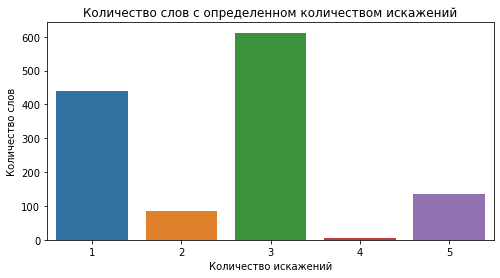

,distortions,distortions_amount,difficulty
word,,,
большинство,"[большиннфство, большиннство, большинвство, бо...",5,0.5
вернуться,"[вернутся, вирнутся, вирнуться]",3,0.5
вперед,"[впирид, впиред, вперид]",3,0.5
все-таки,"[взе-таки, все таки, всетаки, взе таки, взетаки]",5,0.5
доджсона,"[даджсона, доджсана, даджсана]",3,0.5
...,...,...,...
поспешно-остановилась,"[поспешно остановилась, поспешноостановилась]",2,1.0
постепенностью,[постепеностью],1,1.0
противоречащее,[противоречящее],1,1.0


In [28]:
distortions_df = analyze_distortions(filepath=alice_in_wonderland_fullname, stop=None)
distortions_df.rename_axis('word').sort_values(by=['difficulty', 'word'])

# Весь нужный код

In [29]:
# Функция сложности слова
exec(open('scripts/word_difficulty.py').read())


# Вспомогательные функции
def get_morphs_list(lemma: str) -> List[str]:
    if lemma not in morph_df.index:
        return []
    return list(morph_df.loc[lemma]['analysis'].split('/'))

stress_vowels_dict = {'о':'а', 'е':'и'}

def stress_vowels_distortion(word: str, morphs_list: List[str]=[]) -> List[str]:  
    def do_distortion(word: str) -> None:
        stress_word = word
        if morphs_list:
            morphs_str = ''.join(morphs_list)
            stress = 0
            for i in range(len(morphs_str)):
                if morphs_str[i] == '\'':
                    stress_word = stress_word[:i - stress - 1] + morphs_str[i - 1].upper() + morphs_str[i + 1:] 
                    stress += 1
        for i in range(len(word) - 1):
            if i < len(stress_word) and stress_word[i] in stress_vowels_dict and stress_word[i] == word[i]:
                distortion = word[:i] + stress_vowels_dict[word[i]] + word[i + 1:]
                if distortion not in distortions:
                    distortions.add(distortion)
                    do_distortion(distortion)
        
    distortions = set()
    do_distortion(word)
    return list(distortions)

deaf_consonants = set('пфктшсхцчщ')
consonants_pairs = {
    'б':'п', 'п':'б',
    'в':'ф', 'ф':'в',
    'г':'к', 'к':'г',
    'д':'т', 'т':'д',
    'ж':'ш', 'ш':'ж',
    'з':'с', 'с':'з'
}

def consonants_distortion(word: str) -> List[str]:  
    def do_distortion(word: str) -> None:
        for i in range(len(word)):
            distortion = None
            c = word[i] 
            after_c = word[i + 1] if i < len(word) - 1 else None
            if c in deaf_pairs and (i == len(word) - 1 or after_c in deaf_consonants):
                distortion = word[:i] + consonants_pairs[c] + word[i + 1:]
                if distortion not in distortions:
                    distortions.add(distortion)
                    do_distortion(distortion)
        
    distortions = set()
    do_distortion(word)
    return list(distortions)

hissing = set('жчшщ')
vowels_pairs = {'ю':'у', 'у':'ю', 'я':'а', 'а':'я', 'ы':'и', 'и':'ы'}

def vowels_hissing_distortion(word: str) -> List[str]:  
    def do_distortion(word: str) -> None:
        for i in range(len(word)):
            distortion = None
            c = word[i] 
            before_c = word[i - 1] if i > 0 else None
            if before_c in hissing or before_c == 'ц':
                if c in vowels_pairs:
                    distortion = word[:i] + vowels_pairs[c] + word[i + 1:]
            if before_c in hissing:
                if c == 'ё':
                    distortion = word[:i] + 'о' + word[i + 1:]
            if distortion and distortion not in distortions:
                distortions.add(distortion)
                do_distortion(distortion)
        
    distortions = set()
    do_distortion(word)
    return list(distortions)

root_pairs = {'раст':'рост', 'ращ':'рощ', 'рос':'рас',
               'лаг':'лог', 'лож':'лаж',
               'скак':'скок', 'скоч':'скач',
               'гар':'гор', 'гор':'гар', 
               'твар':'твор','твор':'твар', 
               'клан':'клон', 'клон':'клан',
               'зар':'зор', 'зор':'зар',
               'плав':'плов', 'плов':'плав',
               'мак':'мок', 'моч':'мач',
               'равн':'ровн', 'ровн':'равн',
               'бер':'бир', 'бир':'бер',
               'дер':'дир', 'дир':'дер',
               'пер':'пир', 'пир':'пер',
               'тер':'тир', 'тир':'тер',
               'мер':'мир', 'мир':'мер',
               'жег':'жиг', 'жиг':'жег',
               'стел':'стил', 'стил':'стел',
               'блест':'блист', 'блист':'блест',
               'чет':'чит', 'чит':'чет',
               'кас':'кос', 'кос':'кас'}

    
def roots_distortion(word: str, morphs_list: List[str]=[]) -> List[str]:
    def do_distortion(word: str) -> None:
        index = 0
        for morph in morphs_list:
            if morph in root_pairs and morph == word[index:index + len(morph)]:
                distortion = word[:index] + root_pairs[morph] + word[index + len(morph):]
                if distortion not in distortions:
                    distortions.add(distortion)
                    do_distortion(distortion)
            index += len(morph.replace('\'', ''))

    distortions = set()
    do_distortion(word)
    return list(distortions)

prefix_pairs = {'пре':'при', 'при':'пре',
                'без':'бес', 'бес':'без',
                'воз':'вос', 'вос':'воз',
                'вз':'вс', 'вс':'вз',
                'из':'ис', 'ис':'из',
                'низ':'нис', 'нис':'низ',
                'раз':'рас', 'рас':'раз',
                'чрез':'чрес', 'чрес':'чрез'}

def prefixs_distortion(word: str, morphs_list: List[str]=[]) -> List[str]:
    def do_distortion(word: str) -> None:
        index = 0
        for morph in morphs_list:
            if morph in prefix_pairs and morph == word[index:index + len(morph)]:
                distortion = word[:index] + prefix_pairs[morph] + word[index + len(morph):]
                if distortion not in distortions:
                    distortions.add(distortion)
                    do_distortion(distortion)
            index += len(morph.replace('\'', ''))
        if len(distortions) == 0:
            for key, value in prefix_pairs.items():
                distortion = word.replace(value, key, 1)
                if distortion != word:
                    distortions.add(distortion)
            
    distortions = set()
    do_distortion(word)
    return list(distortions)

postfix_pairs = {'тся':'ться', 'ться':'тся'}

def postfixs_distortion(word: str) -> List[str]:
    for postfix in postfix_pairs:
        if word[-len(postfix):] == postfix:
            return [word[:-len(postfix)] + postfix_pairs[postfix]]
    return []

vowels = set('аяоёуюыиэе')

def two_in_row_distortion(word: str) -> List[str]:
    def do_distortion(word: str) -> None:
        for i in range(len(word) - 2):
            if i > 0 and word[i - 1] == word[i] and word[i] not in vowels:
                distortion = word[:i] + word[i + 1:]
                if distortion not in distortions:
                    distortions.add(distortion)
                    do_distortion(distortion)
            
    distortions = set()
    do_distortion(word)
    return list(distortions)

single_suffixs = set(['ан', 'ян', 'ын', 'ин'])

def duplicate_distortion(word: str, morphs_list: List[str]) -> List[str]:
    def do_distortion(word: str) -> None:
        index = 0
        for morph in morphs_list:
            morph = morph.replace('\'', '')
            if morph in single_suffixs and morph == word[index:index + len(morph)] and\
                index + len(morph) < len(word) and word[index + len(morph) - 1] != word[index + len(morph)]:
                    distortion = word[:index] + morph + 'н' + word[index + len(morph):]
                    if distortion not in distortions:
                        distortions.add(distortion)
                        do_distortion(distortion)
            index += len(morph)
            
    distortions = set()
    do_distortion(word)
    return list(distortions)

silent_consonants_dict = {'стн':'сн',
                          'стл':'сл',
                          'ндш':'нш',
                          'ндц':'нц',
                          'нтг':'нг',
                          'здн':'зн',
                          'здц':'зц',
                          'рдц':'рц',
                          'рдч':'рч',
                          'лнц':'нц',
                          'вств':'ств'}

def silent_consonants_distortion(word: str) -> List[str]:
    def do_distortion(word: str) -> None:
        for key, value in silent_consonants_dict.items():
            distortion = word.replace(key, value, 1)
            if distortion != word and distortion not in distortions:
                distortions.add(distortion)
                do_distortion(distortion)
        if len(distortions) == 0:
            for key, value in silent_consonants_dict.items():
                distortion = word.replace(value, key, 1)
                if distortion != word:
                    distortions.add(distortion)
    
    distortions = set()
    do_distortion(word)
    return list(distortions)

def hard_sign_distortion(word: str) -> List[str]:
    if 'ъ' in set(word):
        return [word.replace('ъ', 'ь', 1)]
    return []

def hyphen_distortion(word: str) -> List[str]:
    if '-' in set(word):
        return [word.replace('-', ' '), word.replace('-', '')]
    return []


# Основная функция сложности слова
def create_distortions(word: str, lemma: str, max_amount: int=6) -> List[str]:
    morphs_list=get_morphs_list(lemma)    
    distortions = set([word])
    
    def do_function(func, morphs=False) -> None:
        result = set()
        for distortion in distortions:     
            result.update(func(distortion, morphs_list) if morphs else func(distortion))
        if len(distortions | result) <= max_amount:
            distortions.update(result)     

    do_function(roots_distortion, morphs=True)
    do_function(prefixs_distortion, morphs=True)
    do_function(postfixs_distortion)
    do_function(two_in_row_distortion)
    do_function(duplicate_distortion, morphs=True)
    do_function(silent_consonants_distortion)
    do_function(hard_sign_distortion)
    do_function(hyphen_distortion)
    do_function(stress_vowels_distortion, morphs=True)
    do_function(consonants_distortion)
    do_function(vowels_hissing_distortion)
    
    distortions.remove(word)
    return list(distortions)


# Функции анализа искажений .txt
def countplot_distortions_df(distortions_df: pd.DataFrame) -> None:
    print('Всего слов: {}'.format(len(distortions_df)))
    print('Слов без искажений: {}'.format(len(distortions_df[distortions_df['distortions_amount'] == 0])))
    print('Слов с искажениями: {}'.format(len(distortions_df[distortions_df['distortions_amount'] != 0])))
    
    fig, ax = plt.subplots(figsize=(8, 4))
    
    sns.countplot(x=distortions_df[distortions_df['distortions_amount'] != 0]['distortions_amount'])
    ax.set_title('Количество слов с определенном количеством искажений')
    ax.set_ylabel('Количество слов')
    ax.set_xlabel('Количество искажений')
    
    plt.show()
    
def analyze_distortions(filepath: str, stop=None, show_plot=True) -> pd.DataFrame:
    distortions_df = pd.DataFrame(columns=['distortions', 'distortions_amount'])
    with open(filepath, 'rb') as f:
        for i, word in enumerate(tqdm(f.read().decode('utf-8').split())):
            word = transform_word(word)[0]
            if word and word not in distortions_df.index:
                difficulty = word_difficulty(word)
                if 0.5 <= difficulty['difficulty']:
                    distortions = create_distortions(word, difficulty['lemma'])
                    info = {'distortions': distortions,
                            'distortions_amount': len(distortions),
                            'difficulty': difficulty['difficulty']}
                    row = pd.Series(info, name=word)
                    distortions_df = distortions_df.append(row)
            if stop and stop <= i:
                break
    if show_plot:
        countplot_distortions_df(distortions_df)
    return distortions_df